### 在实际的使用时，我们不仅仅要对transformer模型进行高效的微调，还要进行量化，因为模型的体积太大会大大增加显存的消耗以及性能、储存的消耗。

In [ ]:
!pip install gptqmodel --no-build-isolation

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [2]:
import datasets

In [3]:
dataset = datasets.load_dataset("wiki_qa")

In [4]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 6165
    })
    validation: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 2733
    })
    train: Dataset({
        features: ['question_id', 'question', 'document_title', 'answer', 'label'],
        num_rows: 20360
    })
})


In [5]:
input_dataset = dataset["train"].select_columns(["question", "answer"])

In [6]:
print(input_dataset)

Dataset({
    features: ['question', 'answer'],
    num_rows: 20360
})


### 注意datasets这个类型的对象的方法都很特别，如果要选择前面多少个数据的话使用`selct()`,以及我们的这个对象可以使用`select_columns()`,`remove_columns()`方法

In [7]:
input_before_convert = input_dataset.select(range(2500))

In [8]:
print(input_before_convert)

Dataset({
    features: ['question', 'answer'],
    num_rows: 2500
})


In [9]:
print(input_before_convert["question"][:3])

['how are glacier caves formed?', 'how are glacier caves formed?', 'how are glacier caves formed?']


In [10]:
def convert_to_openchat(example):
    messages = [
        {"role": "user", "content": example["question"]},
        {"role": "assistant", "content": example["answer"]}
    ]
    return {"messages": messages}


In [11]:
inputs = input_before_convert.map(convert_to_openchat, batched=False)

In [12]:
print(inputs)

Dataset({
    features: ['question', 'answer', 'messages'],
    num_rows: 2500
})


In [13]:
print(inputs["messages"][:3])

[[{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'A partly submerged glacier cave on Perito Moreno Glacier .', 'role': 'assistant'}], [{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'The ice facade is approximately 60 m high', 'role': 'assistant'}], [{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'Ice formations in the Titlis glacier cave', 'role': 'assistant'}]]


In [14]:
inputs.to_json("./wiki_qa_2500.jsonl")

Creating json from Arrow format:   0%|          | 0/3 [00:00<?, ?ba/s]

1139456

### json文件不分先后顺序，因为jsonl，json不含有语序

## 可以看到我的数据结构是Ollama官方推荐的格式：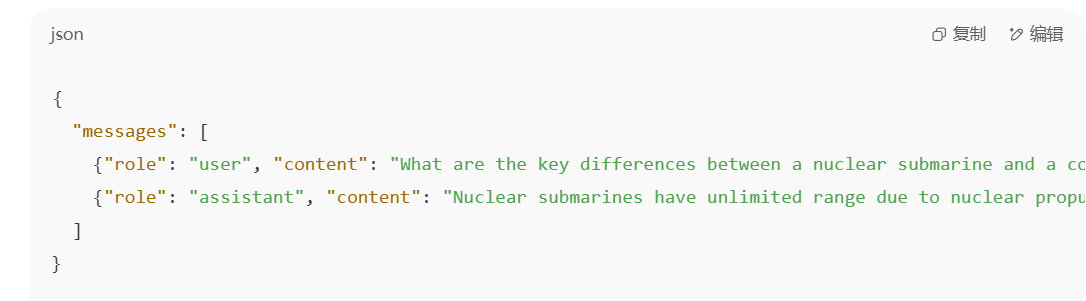

### 但是注意哈，这个训练时候的数据格式和后面进行推理的时候还是有些许的不同，例如我的数据集这个dictionary只有一个key，但是推理的时候会至少有2个key，一个是模型的名字，一个是数据集messages，Ollama返回的数据集是一个json文件，需要解码然后在获取其中的message，不带有s，然后message里面的内容其实就是content有用

In [15]:
print(inputs["messages"][:3])

[[{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'A partly submerged glacier cave on Perito Moreno Glacier .', 'role': 'assistant'}], [{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'The ice facade is approximately 60 m high', 'role': 'assistant'}], [{'content': 'how are glacier caves formed?', 'role': 'user'}, {'content': 'Ice formations in the Titlis glacier cave', 'role': 'assistant'}]]


In [16]:
tokenizer = AutoTokenizer.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6")

In [17]:
print(tokenizer.chat_template)

{% for message in messages %}
{% if message['role'] == 'user' %}
{{ '<|user|>
' + message['content'] + eos_token }}
{% elif message['role'] == 'system' %}
{{ '<|system|>
' + message['content'] + eos_token }}
{% elif message['role'] == 'assistant' %}
{{ '<|assistant|>
'  + message['content'] + eos_token }}
{% endif %}
{% if loop.last and add_generation_prompt %}
{{ '<|assistant|>' }}
{% endif %}
{% endfor %}


### 每一个模型（huggingface）都有自己的模板，这个没有，很奇怪，所以我们要自己定义一个，或者是下载一个模板

### 这里是把训练数据转换成模型的对话模板chat_templete，一般huggingface上面下载的模型都会有这个东西，`model.chat_templete`属性,然后使用tokenizer的方法`apply_chat_templete()`转换成模板格式，在进行我们的分词，注意的是后面往数据集合中加入标签值时，记住要把标签值`copy()`，不然会导致标签的地址和input_ids的地址是一样的，造成麻烦

### 如果要使用 `apply_chat_templete()`的话，数据格式要是[{"role":xxxx, "content":xxxxx}, {"role":xxxx, "content":xxxxx}，.........] 这样的形式，也就是我们的chat_template的转换需要的数据格式

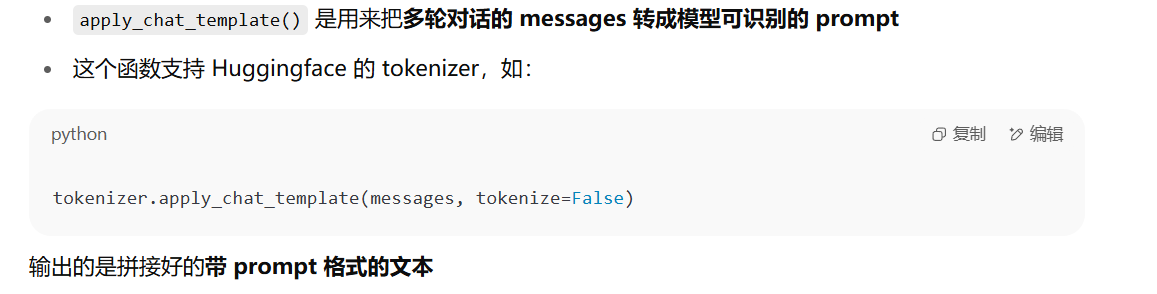
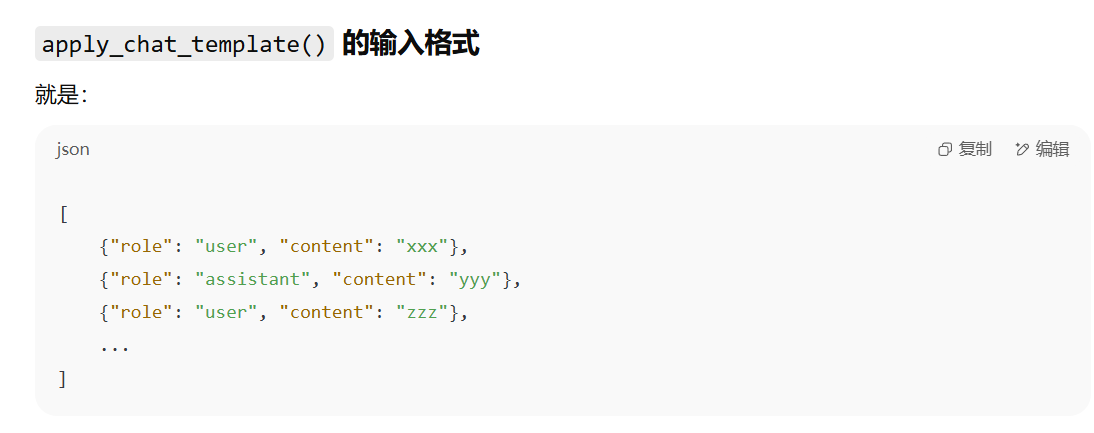

In [18]:
tokenizer.apply_chat_template(inputs["messages"][:1], tokenize=False)

['<|user|>\nhow are glacier caves formed?</s>\n<|assistant|>\nA partly submerged glacier cave on Perito Moreno Glacier .</s>\n']

In [19]:
def apply_templete(example):
    prompt = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
    )
    tokenized = tokenizer(prompt, truncation=True, max_length=128, padding="max_length")
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

In [20]:
dataset = inputs.map(apply_templete)

In [21]:
print(dataset)

Dataset({
    features: ['question', 'answer', 'messages', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2500
})


In [22]:
print(dataset["input_ids"][:2])

[[1, 529, 29989, 1792, 29989, 29958, 13, 3525, 526, 14751, 13241, 274, 5989, 8429, 29973, 2, 29871, 13, 29966, 29989, 465, 22137, 29989, 29958, 13, 29909, 22669, 1014, 1050, 3192, 14751, 13241, 24230, 373, 2431, 2049, 3879, 8154, 19798, 13241, 869, 2, 29871, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [1, 529, 29989, 1792, 29989, 29958, 13, 3525, 526, 14751, 13241, 274, 5989, 8429, 29973, 2, 29871, 13, 29966, 29989, 465, 22137, 29989, 29958, 13, 1576, 14890, 4024, 1943, 338, 14235, 29871, 29953, 29900, 286, 1880, 2, 29871, 13, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [23]:
dataset.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

### 被自己蠢哭，被自己的傻逼程度感到难甭，发现可以使用ollama直接量化gguf格式的文件，man what can i say

### 那么首先还是进行lora微调然后使用lora合并原本模型和自己的模型

In [24]:
from peft import PeftModel, TaskType, get_peft_model, LoraConfig
from transformers import AutoTokenizer, AutoModelForCausalLM


In [25]:
lora_config = LoraConfig(
    r=6,
    lora_alpha=16,
    task_type=TaskType.CAUSAL_LM,
    lora_dropout=0.1
)

In [26]:
base_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6", device_map="auto")
tokenizer = tokenizer

In [27]:
lora_model = get_peft_model(base_model, lora_config)


INFO  ENV: Auto setting PYTORCH_CUDA_ALLOC_CONF='expandable_segments:True' for memory saving.
INFO  ENV: Auto setting CUDA_DEVICE_ORDER=PCI_BUS_ID for correctness.          


In [28]:
lora_model.print_trainable_parameters()

trainable params: 844,800 || all params: 1,100,893,184 || trainable%: 0.0767


In [29]:
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim import AdamW
import numpy as np

In [30]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
optimizer = AdamW(lora_model.parameters(), lr=5e-5)
lora_model.train()

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 2048)
        (layers): ModuleList(
          (0-21): 22 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2048, out_features=6, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=6, out_features=2048, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): Linear(in_featu

In [31]:
for epoch in range(3):
    mean_loss = []
    for batch in tqdm(dataloader, desc=f"epoch: {epoch + 1}"):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to("cuda")
        attention_mask = batch["attention_mask"].to("cuda")
        labels = batch["labels"].to("cuda")

        outputs = lora_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        mean_loss.append(loss.item())

        optimizer.step()

    print(f"mean loss of epoch:{epoch + 1} is {np.mean(mean_loss)}")

epoch: 1: 100%|██████████| 157/157 [07:08<00:00,  2.73s/it]


mean loss of epoch:1 is 3.109237652295714


epoch: 2: 100%|██████████| 157/157 [08:43<00:00,  3.34s/it]


mean loss of epoch:2 is 0.9791190388855661


epoch: 3: 100%|██████████| 157/157 [08:00<00:00,  3.06s/it]

mean loss of epoch:3 is 0.89349180194223


In [32]:
lora_model.save_pretrained("merged_lora_model/Adapter")
tokenizer.save_pretrained("merged_lora_model/base_model/")
base_model = AutoModelForCausalLM.from_pretrained("TinyLlama/TinyLlama-1.1B-Chat-v0.6").save_pretrained("merged_lora_model/base_model/")

In [33]:
from torch import cuda

In [34]:
cuda.empty_cache()

### 现在我们的模型已经量化并且合并了模型，现在进行我的模型的格式的转换，使用llama.cpp的格式转换的脚本进行转换，现在改名了,在llama.cpp中，名字叫做`convert_hf_to_gguf.py`

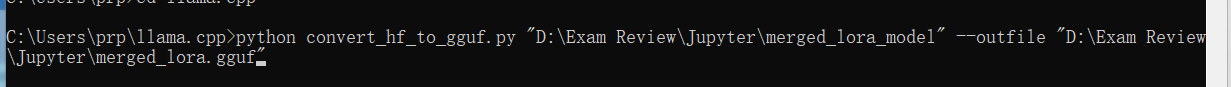

### 在安装llama.cpp的文件夹上使用编写好的脚本，使用`--outfile`指定输出位置以及文件的名字，然后得到转换格式后的模型

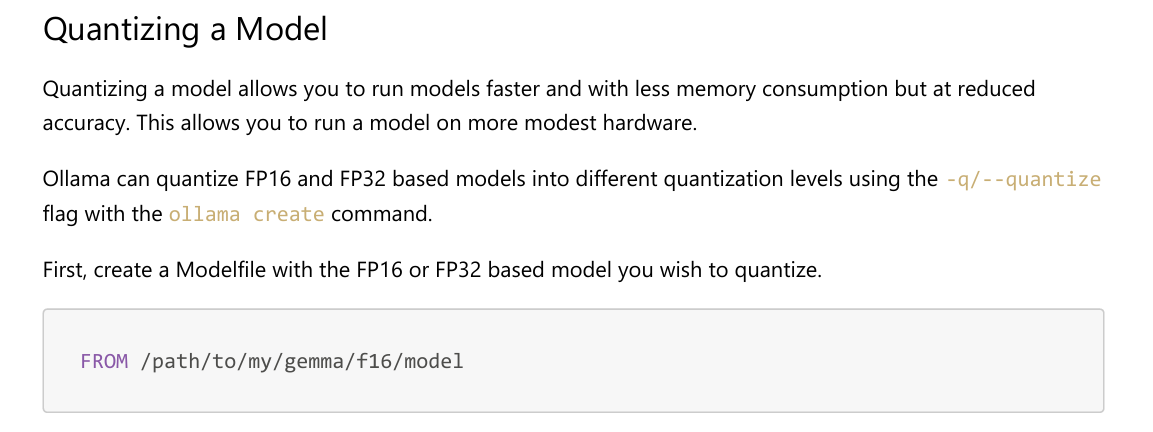

### 根据Ollama官方的文档讲述，在gguf文件的根目录下加入一个Modelfile，然后里面写出gguf文件的位置，当然直接使用`.`就行（本文件夹）

## 注意！关于Modelfile的更多的设置的方式见ollama的官方文档`Modelfile`，另外在平板的ollama笔记中包含有go模板语言的学习，当然在另外一个文件中我也提出了如何寻找自己的数据以及微调一个基础模型（没有对话模板，没有经过对话专项训练）成为简单的qa或者是chat模型的过程

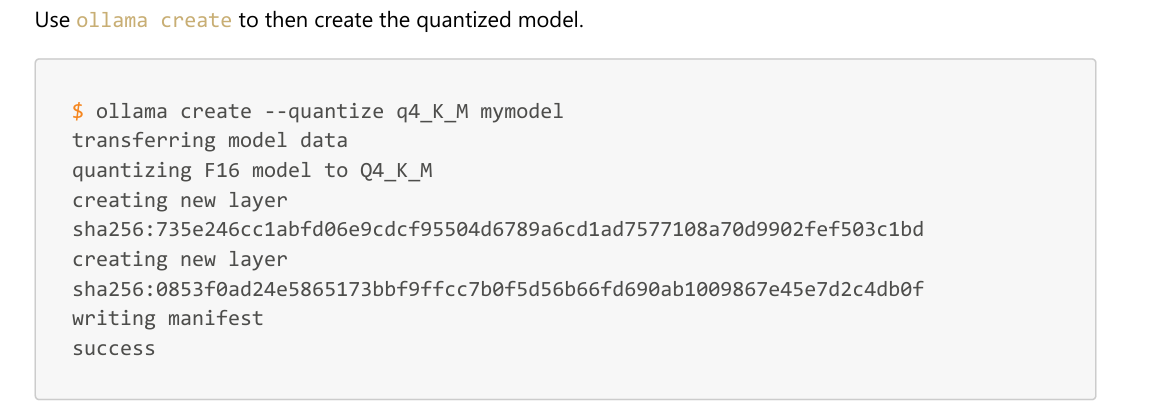

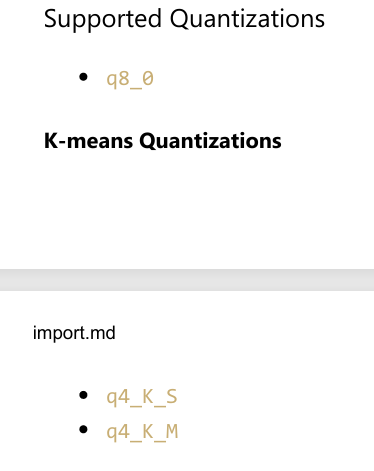

### 根据官方文档，其中支持这三种量化的方式以及支持使用Ollama create 直接量化并创建模型

### 使用ollama run 测试或是像之前一样使用ollama API 配合gradio进行部署

### 上面的方法是使用lora进行微调之后然后进行我的量化，那么可不可以反过来呢？首先进行量化模型，然后对我的模型lora调参，这样肯定会更快！这种方式叫做`QLora`

### 所以思路如下，使用llama.cpp工具进行量化之后进行参数的调试，最后合并权重转换成gguf，输入给我的ollama

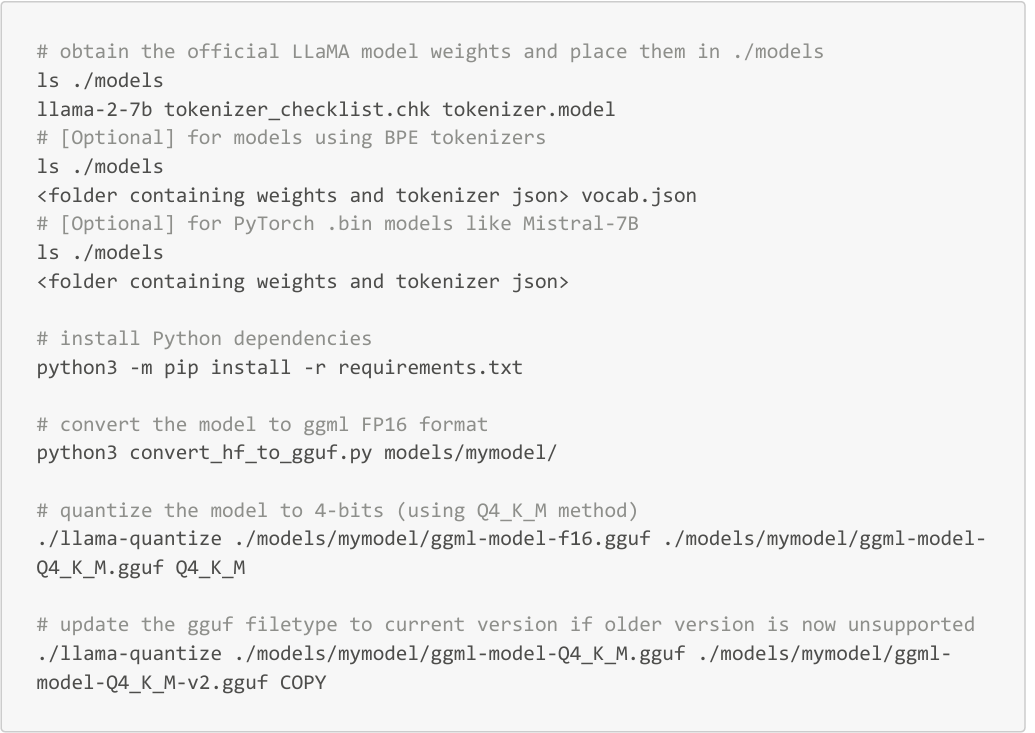

上面是官方给的llama.cpp的量化的教程，现在来进行学习：
1. 第一行：官方在说我们的模型文件夹中要有什么内容

2. 第二第三行都是可选择的项，通常用于不同的模型，因为不同的模型他们选择的分词器也是不同的

3. 第四行：讲述了在linux系统中如何安装我们的依赖，便于我们的llama.cpp的使用

4. 关键的一步： 进行量化的命令行的语法是： `llama.cpp目录/llama-quantize 量化前的模型的存放位置(必须指明文件.gguf) 存放量化后模型的位置(必须指明文件.gguf) 想要量化的格式`

如果说llama-quantize安装进了环境变量的话，那么可以使用`llama-quantize 量化前的模型的存放位置(必须指明文件.gguf) 存放量化后模型的位置(必须指明文件.gguf) 想要量化的格式` 这样的命令的格式

5. 更新模型的格式到最新的gguf格式：仅仅在不支持老格式的时候进行更新

### 现在来进行QLora的尝试

### 上面的tinyllama的尝试并不行，可恶的meta不给我llama的权限妈的，所以我在这里尝试使用deepseek

### sb了 ChatGpt不给我说清楚，都是量化，但是不是使用llama.cpp量化，这个是不可逆的是只能读取的，要用的是bitesanbytes进行可逆的量化

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer

In [8]:
deepseek = AutoModelForCausalLM.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/DeepSeek-R1-Distill-Llama-8B")

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]